<a href="https://colab.research.google.com/github/wko1014/GAN_Study/blob/main/notes/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import APIs
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Download MNIST Dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST_data/data/", one_hot=True)

Extracting ./MNIST_data/data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/data/t10k-labels-idx1-ubyte.gz


In [ ]:
# Define Hyperparameters and Placehoders
epochs = 100
batch_size = 100
learning_rate = 0.0002
n_noise = 128
n_image = 28 * 28 # The size of MNIST
n_class = 10 # 0~9

X = tf.placeholder(tf.float32, [None, n_image])
Y = tf.placeholder(tf.float32, [None, n_class])
Z = tf.placeholder(tf.float32, [None, n_noise])

In [ ]:
# Define Modules
def get_params(name, shape):
  weight = tf.get_variable(name=name+"w", shape=shape, initializer=tf.random_normal_initializer(stddev=0.01))
  filtercnt = shape[-1]
  bias = tf.get_variable(name=name+"b", shape=[filtercnt], initializer=tf.zeros_initializer)
  return weight, bias

In [ ]:
# Define Generator (George)
def generator(noise, labels):
    with tf.variable_scope("george"):
        inputs = tf.concat([noise, labels], axis=1)

        G_w1, G_b1 = get_params(name="g_layer1", shape=[n_noise + n_class, 256])
        layer1 = tf.nn.relu(tf.matmul(inputs, G_w1) + G_b1)

        G_wo, G_bo = get_params(name="g_output_layer", shape=[256, n_image])
        output = tf.nn.sigmoid(tf.matmul(layer1, G_wo) + G_bo)
    return output

In [ ]:
# Define Discriminator (Danielle)
def discriminator(image, labels, reuse=False):
    with tf.variable_scope("danielle", reuse=reuse):
        inputs = tf.concat([image, labels], axis=1)

        D_w1, D_b1 = get_params(name="d_layer1", shape=[n_image + n_class, 256])
        layer1 = tf.nn.relu(tf.matmul(inputs, D_w1) + D_b1)

        D_wo, D_bo = get_params(name="d_output_layer", shape=[256, 1])
        output = tf.nn.sigmoid(tf.matmul(layer1, D_wo) + D_bo)
    return output

In [ ]:
# Sample Random Noise Vector
def get_noise(batch_size, n_noise):
  # return np.random.uniform(size=(batch_size, n_noise))
  return np.random.normal(size=(batch_size, n_noise))

# George Generates Counterfeits
counterfeits = generator(noise=Z, labels=Y)

# Danielle Discriminates Real Bills and Counterfeits
D_counterfeits = discriminator(counterfeits, Y)
D_real = discriminator(X, Y, reuse=True)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# GANs Objective Function
loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_counterfeits))
loss_G = tf.reduce_mean(tf.log(1 - D_counterfeits))

# Collect George's and Danielle's Variables
D_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="danielle")
G_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="george")

# Optimization using Adam Optimizer
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D, var_list=D_var_list)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(loss_G, var_list=G_var_list)

In [ ]:
# Nerual Networks Training
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples / batch_size)
loss_var_D, loss_var_G = 0, 0

for epoch in range(epochs):
    for batch in range(total_batch):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        _, loss_val_D = sess.run([train_D, loss_D], feed_dict={X: batch_x, Y:batch_y, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G], feed_dict={Y: batch_y, Z: noise})


    print("Epoch:", "%04d" % epoch, "D loss: {:.4}".format(loss_val_D), "G loss: {:.4}".format(loss_val_G))


    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        generated_samples = sess.run(counterfeits, feed_dict={Y: np.eye(sample_size), Z: noise})

        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))

        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(generated_samples[i], (28, 28)))

        plt.savefig("./{}.png".format(str(epoch).zfill(3)), bbox_inches="tight")
        plt.close(fig)

print("Optimization Complete!")

Epoch: 0000 D loss: -0.2571 G loss: -0.07612
Epoch: 0001 D loss: -0.1077 G loss: -0.04438
Epoch: 0002 D loss: -0.0499 G loss: -0.02027
Epoch: 0003 D loss: -0.09698 G loss: -0.04209
Epoch: 0004 D loss: -0.3631 G loss: -0.2049
Epoch: 0005 D loss: -0.06476 G loss: -0.03243
Epoch: 0006 D loss: -0.2415 G loss: -0.07803
Epoch: 0007 D loss: -0.1875 G loss: -0.08236
Epoch: 0008 D loss: -0.3178 G loss: -0.145
Epoch: 0009 D loss: -0.1205 G loss: -0.04395
Epoch: 0010 D loss: -0.1893 G loss: -0.09223
Epoch: 0011 D loss: -0.2998 G loss: -0.0911
Epoch: 0012 D loss: -0.2434 G loss: -0.1162
Epoch: 0013 D loss: -0.1584 G loss: -0.07268
Epoch: 0014 D loss: -0.6223 G loss: -0.223
Epoch: 0015 D loss: -0.3367 G loss: -0.1028
Epoch: 0016 D loss: -0.2903 G loss: -0.1084
Epoch: 0017 D loss: -0.1478 G loss: -0.08511
Epoch: 0018 D loss: -0.1828 G loss: -0.07755
Epoch: 0019 D loss: -0.2633 G loss: -0.1031
Epoch: 0020 D loss: -0.2973 G loss: -0.1087
Epoch: 0021 D loss: -0.277 G loss: -0.117
Epoch: 0022 D loss: -0

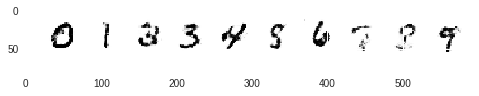

In [ ]:
import matplotlib.image as mpimg

img = mpimg.imread("./099.png")
plt.imshow(img)
plt.show()